## *FBE551: Quantitative Investing* Final Project

**Team Name:**

    JPMarshall

**Team Members:**

    Yi LIU
    Hao WANG
    Siqin YANG
    Sijia ZENG


In this notebook, we implement three different methods, **Assigned Weights, Set Methods, Linear Regression** to combine results produced by four individual strategies.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
# import statsmodels.stats.weightstats as st
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

## Data Preprocess

In [2]:
data = pd.read_csv('./Data/output.csv')
data = data.set_index(['PERMNO','DATE'])
data.head()

PRC  SHROUT  SHRCD  EXCHCD   SICCD    VOL       RET  \
PERMNO  DATE                                                                 
10001.0 1993-01-29 -14.000  1080.0   11.0     3.0  4920.0   44.0  0.000000   
        1993-02-26  14.250  1080.0   11.0     3.0  4920.0   23.0  0.017857   
        1993-03-31  14.250  1075.0   11.0     3.0  4920.0  137.0  0.011053   
        1993-04-30 -15.250  1075.0   11.0     3.0  4920.0  473.0  0.070175   
        1993-05-28 -15.125  1075.0   11.0     3.0  4920.0  126.0 -0.008197   

                    DIVAMT         MV  Payout_QUINTILE  ...  quantile_q6_ma1  \
PERMNO  DATE                                            ...                    
10001.0 1993-01-29     NaN -15120.000              0.0  ...              NaN   
        1993-02-26     NaN  15390.000              0.0  ...              2.0   
        1993-03-31  0.1575  15318.750              0.0  ...              4.0   
        1993-04-30     NaN -16393.750              0.0  ...              3.0   
        1993-05-28     NaN -16259.375              0.0  ...              5.0   

                    quantile_q6_ma2  quantile_q7_ma1  quantile_q7_ma2  \
PERMNO  DATE                                                            
10001.0 1993-01-29              NaN              NaN              NaN   
        1993-02-26              NaN              3.0              NaN   
        1993-03-31              3.0              5.0              4.0   
        1993-04-30              4.0              4.0              4.0   
        1993-05-28              5.0              6.0              6.0   

                    quantile_q8_ma1  quantile_q8_ma2  quantile_q9_ma1  \
PERMNO  DATE                                                            
10001.0 1993-01-29              NaN              NaN              NaN   
        1993-02-26              3.0              NaN              3.0   
        1993-03-31              5.0              4.0              6.0   
        1993-04-30              4.0              5.0              5.0   
        1993-05-28              7.0              6.0              8.0   

                    quantile_q9_ma2  quantile_q10_ma1  quantile_q10_ma2  
PERMNO  DATE                                                             
10001.0 1993-01-29              NaN               NaN               NaN  
        1993-02-26              NaN               4.0               NaN  
        1993-03-31              4.0               7.0               5.0  
        1993-04-30              5.0               5.0               6.0  
        1993-05-28              7.0               9.0               8.0  

[5 rows x 24 columns]

In *reserval* strategy, we choose ```'quantile_q10_ma1'``` as the optimal result.

In [3]:
data = data[['RET', 'Payout_QUINTILE', 'Volatility_QUINTILE', 
             'Momentum_QUINTILE', 'quantile_q10_ma1']].copy()
data.columns = ['RET','Payout_QUINTILE', 'Volatility_QUINTILE', 
                'Momentum_QUINTILE', 'Reversal_QUINTILE']

In [4]:
# create RET_lead for linear regression
data['RET_lead'] = data.groupby('PERMNO')['RET'].shift(-1)

drop NAs due to
- For each strategy, we drop records whose ```RET``` is nan;
- Some records are dropped due to lagging;
- In Volatility and Payout Yield, small companies are removed.

On the other hand, as *RET_lead* is only used for *Linear Regression* method, NAs resulted from *RET_lead* is handled only in *Linear Regression* method.

In [5]:
data.loc[data['Payout_QUINTILE']==0, 'Payout_QUINTILE'] = np.nan
data.loc[data['Volatility_QUINTILE']==0, 'Volatility_QUINTILE'] = np.nan
data.loc[data['Momentum_QUINTILE']==0, 'Momentum_QUINTILE'] = np.nan
data.dropna(subset=['RET', 'Payout_QUINTILE', 'Volatility_QUINTILE',
                   'Momentum_QUINTILE', 'Reversal_QUINTILE'], inplace=True)

In [6]:
data.isna().sum()

RET                        0
Payout_QUINTILE            0
Volatility_QUINTILE        0
Momentum_QUINTILE          0
Reversal_QUINTILE          0
RET_lead               15353
dtype: int64

In [7]:
min_payout, max_payout = data['Payout_QUINTILE'].min(), data['Payout_QUINTILE'].max()
min_vol, max_vol = data['Volatility_QUINTILE'].min(), data['Volatility_QUINTILE'].max()
min_mom, max_mom = data['Momentum_QUINTILE'].min(), data['Momentum_QUINTILE'].max()
min_rev, max_rev = data['Reversal_QUINTILE'].min(), data['Reversal_QUINTILE'].max()

In [8]:
(min_payout, max_payout), (min_vol, max_vol), (min_mom, max_mom), (min_rev, max_rev)

((1.0, 3.0), (1.0, 10.0), (1.0, 5.0), (1.0, 10.0))

## Combination Methods

### Assigned Weights

In [9]:
df = data.copy()
df = df.reorder_levels(['DATE', 'PERMNO'])
df.sort_index(inplace=True)
df.head()

RET  Payout_QUINTILE  Volatility_QUINTILE  \
DATE       PERMNO                                                    
1994-02-28 10001.0  0.000000              1.0                  1.0   
           10002.0 -0.009346              2.0                  3.0   
           10003.0 -0.090909              1.0                  4.0   
           10009.0  0.021972              3.0                  2.0   
           10010.0  0.120000              3.0                  7.0   

                    Momentum_QUINTILE  Reversal_QUINTILE  RET_lead  
DATE       PERMNO                                                   
1994-02-28 10001.0                5.0                2.0 -0.004286  
           10002.0                5.0                6.0  0.004528  
           10003.0                1.0                7.0  0.050000  
           10009.0                5.0                5.0 -0.138889  
           10010.0                1.0                8.0  0.178571

In [10]:
method,sharpe,longs,shorts=[],[],[],[]
for n in ['Payout','Volatility','Momentum','Reversal']:
    method.append(n)
    ports = df[['RET',f'{n}_QUINTILE']].dropna().groupby([f'{n}_QUINTILE','DATE'])['RET'].mean()
    stats = ports.groupby([f'{n}_QUINTILE']).describe()
    stats['sharpe'] = stats['mean'] / stats['std'] * np.sqrt(12)
    if n in ['Volatility','Reversal']:
        shorts.append(stats.iloc[-1,1])
        longs.append(stats.loc[1.0,'mean'])
    else:
        shorts.append(stats.loc[1.0,'mean'])
        longs.append(stats.iloc[-1,1])

In [11]:
weight = pd.DataFrame({'method':method,'shorts':shorts, 'longs':longs})
weight['long-short'] = weight['longs'] - weight['shorts']
weight

,method,shorts,longs,long-short
0,Payout,0.011700,0.012527,0.000827
1,Volatility,0.009902,0.010372,0.000470
2,Momentum,0.009469,0.014930,0.005460
3,Reversal,0.006183,0.023064,0.016882


In [12]:
weight['w']= weight['longs']/weight['longs'].sum()
weight.set_index('method',inplace=True)
weight

,shorts,longs,long-short,w
method,,,,
Payout,0.011700,0.012527,0.000827,0.205727
Volatility,0.009902,0.010372,0.000470,0.170327
Momentum,0.009469,0.014930,0.005460,0.245181
Reversal,0.006183,0.023064,0.016882,0.378764


In [13]:
# Payout has 3 quantiles; Volatility & Reversal have 10 quantiles; Momentum has 5 quantiles.
df.loc[df['Payout_QUINTILE']==min_payout, 'Payout'] = 1.0

In [14]:
for i in ['Payout','Volatility','Momentum','Reversal']:
    if i=='Volatility':
        df.loc[df[f'{i}_QUINTILE']==min_vol, i] = 1.0*weight.loc[i,'w']
        df.loc[df[f'{i}_QUINTILE']==max_vol, i] = -1.0*weight.loc[i,'w']
    elif i=='Payout':
        df.loc[df[f'{i}_QUINTILE']==min_payout, i] = -1.0*weight.loc[i,'w']
        df.loc[df[f'{i}_QUINTILE']==max_payout, i] = 1.0*weight.loc[i,'w']
    elif i=='Reversal':
        df.loc[df[f'{i}_QUINTILE']==min_rev, i] = 1.0*weight.loc[i,'w']
        df.loc[df[f'{i}_QUINTILE']==max_rev, i] = -1.0*weight.loc[i,'w']
    else:
        df.loc[df[f'{i}_QUINTILE']==min_mom, i] = -1.0*weight.loc[i,'w']
        df.loc[df[f'{i}_QUINTILE']==max_mom, i] = 1.0*weight.loc[i,'w']

In [15]:
df.fillna(0,inplace=True)
df['score'] = df['Payout']+df['Volatility']+df['Momentum']+df['Reversal']
df

RET  Payout_QUINTILE  Volatility_QUINTILE  \
DATE       PERMNO                                                    
1994-02-28 10001.0  0.000000              1.0                  1.0   
           10002.0 -0.009346              2.0                  3.0   
           10003.0 -0.090909              1.0                  4.0   
           10009.0  0.021972              3.0                  2.0   
           10010.0  0.120000              3.0                  7.0   
...                      ...              ...                  ...   
2020-12-31 93423.0  0.109665              2.0                  9.0   
           93426.0  0.076239              1.0                  4.0   
           93429.0  0.019711              3.0                  2.0   
           93434.0  0.122605              1.0                  5.0   
           93436.0  0.243252              1.0                  9.0   

                    Momentum_QUINTILE  Reversal_QUINTILE  RET_lead    Payout  \
DATE       PERMNO                                                              
1994-02-28 10001.0                5.0                2.0 -0.004286 -0.205727   
           10002.0                5.0                6.0  0.004528  0.000000   
           10003.0                1.0                7.0  0.050000 -0.205727   
           10009.0                5.0                5.0 -0.138889  0.205727   
           10010.0                1.0                8.0  0.178571  0.205727   
...                               ...                ...       ...       ...   
2020-12-31 93423.0                2.0               10.0  0.000000  0.000000   
           93426.0                2.0                8.0  0.000000 -0.205727   
           93429.0                2.0                6.0  0.000000  0.205727   
           93434.0                4.0                6.0  0.000000 -0.205727   
           93436.0                5.0               10.0  0.000000 -0.205727   

                    Volatility  Momentum  Reversal     score  
DATE       PERMNO                                             
1994-02-28 10001.0    0.170327  0.245181  0.000000  0.209782  
           10002.0    0.000000  0.245181  0.000000  0.245181  
           10003.0    0.000000 -0.245181  0.000000 -0.450908  
           10009.0    0.000000  0.245181  0.000000  0.450908  
           10010.0    0.000000 -0.245181  0.000000 -0.039454  
...                        ...       ...       ...       ...  
2020-12-31 93423.0    0.000000  0.000000 -0.378764 -0.378764  
           93426.0    0.000000  0.000000  0.000000 -0.205727  
           93429.0    0.000000  0.000000  0.000000  0.205727  
           93434.0    0.000000  0.000000  0.000000 -0.205727  
           93436.0    0.000000  0.245181 -0.378764 -0.339310  

[1468850 rows x 11 columns]

In [16]:
def quintiles(inser, i=2):
    outser = pd.qcut(inser, q=i, labels=range(1,i+1))
    return outser

In [17]:
df.loc[df['score']>0.5, 'd'] = 1.0
df.loc[df['score']<-0.5, 'd'] = -1.0

In [18]:
df['d'].value_counts()

-1.0    89905
 1.0    59226
Name: d, dtype: int64

**strategy performance**

define function to return long portfolio and short portfolio separately, along with its statistics

In [19]:
def calc_port_stats(data, strategy_col):
    ports = data[['RET', strategy_col]].dropna().groupby([strategy_col, 'DATE'])['RET'].mean()
    stats = ports.groupby([strategy_col]).describe()
    stats['sharpe_annual'] = stats['mean'] / stats['std'] * np.sqrt(12)
    stats['tstat'] = stats['mean'] / (stats['std'] / np.sqrt(stats['count']))
    stats = stats.T
    stats.columns = ['short', 'long']
    
    return ports, stats

define function to return the statistics of the final long-short portfolio

In [20]:
# long_short = pd.DataFrame(columns=['RET'])
# # long_short.loc['count'] = np.array(list(set(stats.loc['count'])))
# long_short.loc['mean'] = stats.loc['mean','long'] - stats.loc['mean','short']
# long_short
# tstat, _, _ = st.ttest_ind(ports[1], ports[-1], usevar='unequal')
# tstat # somehow different answer
def calc_long_short_stats(ports):
    long = ports.loc[1]
    short = ports.loc[-1]
    rets = long - short
#     if len(long)>=len(short):
    rets = rets.combine_first(long)
#     else:
    rets = rets.combine_first(-short)
    assert rets.isna().sum()==0, 'Missing Values!'
    stats = rets.describe()
    stats['sharpe_annual'] = stats['mean'] / stats['std'] * np.sqrt(12) #np.sqrt(250)
    stats['tstat'] = stats['mean'] / (stats['std'] / np.sqrt(stats['count']))
    stats = pd.DataFrame(stats)
    stats.columns = ['long-short']
    
    return rets, stats

In [21]:
ports, stats = calc_port_stats(df, strategy_col='d')
stats

,short,long
count,323.000000,323.000000
mean,0.000620,0.016712
std,0.084763,0.058166
min,-0.244185,-0.267678
25%,-0.043467,-0.007323
50%,0.001517,0.018152
75%,0.044602,0.043241
max,0.493329,0.310396
sharpe_annual,0.025358,0.995259
tstat,0.131561,5.163529


In [22]:
rets_ass_wgts, stats = calc_long_short_stats(ports)
stats

,long-short
count,323.000000
mean,0.016091
std,0.062586
min,-0.429051
25%,-0.014268
50%,0.014814
75%,0.048429
max,0.301760
sharpe_annual,0.890634
tstat,4.620723


### Set Methods

In [23]:
df = data.copy()

#### Union Method

![alt text](./Data/Set_Method1.png "Method #1")

First, create two sets for long and short simply by unioning all stocks from four individual strategies.

Then, remove the intersection part and long-short the rest.

In [24]:
df['long_method1'] = np.NaN
df['short_method1'] = np.NaN
df.loc[(df['Payout_QUINTILE']==max_payout) | 
       (df['Volatility_QUINTILE']==min_vol) |
       (df['Momentum_QUINTILE']==max_mom) |
       (df['Reversal_QUINTILE']==min_rev), 'long_method1'] = 1
df.loc[(df['Payout_QUINTILE']==min_payout) | 
       (df['Volatility_QUINTILE']==max_vol) |
       (df['Momentum_QUINTILE']==min_mom) |
       (df['Reversal_QUINTILE']==max_rev), 'short_method1'] = 1

In [25]:
df.loc[(df['long_method1']==1) & (df['short_method1']==1)]

RET  Payout_QUINTILE  Volatility_QUINTILE  \
PERMNO  DATE                                                         
10001.0 1994-02-28  0.000000              1.0                  1.0   
        1994-03-31 -0.004286              1.0                  1.0   
        1995-07-31  0.000000              3.0                  1.0   
        1995-08-31 -0.030303              3.0                  1.0   
        1995-09-29  0.043750              1.0                  1.0   
...                      ...              ...                  ...   
93436.0 2020-08-31  0.741452              1.0                  8.0   
        2020-09-30 -0.139087              1.0                  9.0   
        2020-10-30 -0.095499              1.0                  9.0   
        2020-11-30  0.462736              1.0                  9.0   
        2020-12-31  0.243252              1.0                  9.0   

                    Momentum_QUINTILE  Reversal_QUINTILE  RET_lead  \
PERMNO  DATE                                                         
10001.0 1994-02-28                5.0                2.0 -0.004286   
        1994-03-31                5.0                6.0 -0.144928   
        1995-07-31                1.0                7.0 -0.030303   
        1995-08-31                1.0                4.0  0.043750   
        1995-09-29                2.0                3.0 -0.030303   
...                               ...                ...       ...   
93436.0 2020-08-31                5.0               10.0 -0.139087   
        2020-09-30                5.0               10.0 -0.095499   
        2020-10-30                5.0                2.0  0.462736   
        2020-11-30                5.0                2.0  0.243252   
        2020-12-31                5.0               10.0       NaN   

                    long_method1  short_method1  
PERMNO  DATE                                     
10001.0 1994-02-28           1.0            1.0  
        1994-03-31           1.0            1.0  
        1995-07-31           1.0            1.0  
        1995-08-31           1.0            1.0  
        1995-09-29           1.0            1.0  
...                          ...            ...  
93436.0 2020-08-31           1.0            1.0  
        2020-09-30           1.0            1.0  
        2020-10-30           1.0            1.0  
        2020-11-30           1.0            1.0  
        2020-12-31           1.0            1.0  

[343000 rows x 8 columns]

**strategy performance**

In [26]:
df['method1'] = np.NaN
df.loc[(df['long_method1']==1) & (df['short_method1']!=1), 'method1'] = 1
df.loc[(df['long_method1']!=1) & (df['short_method1']==1), 'method1'] = -1

In [27]:
ports, stats = calc_port_stats(df, strategy_col='method1')
stats

,short,long
count,323.000000,323.000000
mean,0.007670,0.013165
std,0.070797,0.046763
min,-0.238110,-0.228271
25%,-0.030612,-0.008792
50%,0.010436,0.016678
75%,0.042251,0.040727
max,0.280725,0.174821
sharpe_annual,0.375305,0.975240
tstat,1.947131,5.059670


In [28]:
rets_union, stats = calc_long_short_stats(ports)
stats

,long-short
count,323.000000
mean,0.005495
std,0.039005
min,-0.185460
25%,-0.011536
50%,0.006388
75%,0.026061
max,0.134633
sharpe_annual,0.487989
tstat,2.531749


**Insight**: in this case, as short does not produce a negative return, only long stocks would be more profitable compared to long-short strategy.

#### Intersection Method

![alt text](./Data/Set_Method2.png "Method #2")

For long and short sets, simply select the intersection of four individual strategies. 

While there may be no intersection at all, either make no trades that day or loosen the cutoff criteria for larger sets given by individual strategies.

In [29]:
df['long_method2'] = np.NaN
df['short_method2'] = np.NaN
df.loc[(df['Payout_QUINTILE']==max_payout) & 
       (df['Volatility_QUINTILE']==min_vol) &
       (df['Momentum_QUINTILE']==max_mom) &
       (df['Reversal_QUINTILE']==min_rev), 'long_method2'] = 1
df.loc[(df['Payout_QUINTILE']==min_payout) & 
       (df['Volatility_QUINTILE']==max_vol) &
       (df['Momentum_QUINTILE']==min_mom) &
       (df['Reversal_QUINTILE']==max_rev), 'short_method2'] = 1

In [30]:
len(df.loc[(df['long_method2']==1) & (df['short_method2']==1)])

0

In [31]:
len(df.loc[(df['long_method2']==1)]), len(df.loc[(df['short_method2']==1)])

(168, 5920)

**strategy performance**

In [32]:
df['method2'] = np.NaN
df.loc[df['long_method2']==1, 'method2'] = 1
df.loc[df['short_method2']==1, 'method2'] = -1

In [33]:
ports, stats = calc_port_stats(df, strategy_col='method2')
stats

,short,long
count,320.000000,70.000000
mean,-0.014056,0.010621
std,0.174854,0.082460
min,-0.479381,-0.467748
25%,-0.109232,-0.016631
50%,-0.035951,0.010401
75%,0.052007,0.046627
max,1.147094,0.195833
sharpe_annual,-0.278474,0.446190
tstat,-1.438032,1.077651


In [34]:
rets_intersec, stats = calc_long_short_stats(ports)
stats

,long-short
count,320.000000
mean,0.016380
std,0.178113
min,-1.147094
25%,-0.052007
50%,0.040352
75%,0.116209
max,0.479381
sharpe_annual,0.318565
tstat,1.645062


**Insights:** unfortunately, insignificant

therefore, we further explore with a relaxation

**w/ relaxation**

In [35]:
# relax quantiles
long_range, short_range = 2,2
### since Payout_QUINTILE only has three quantiles, no relaxation any more
# long_payout, short_payout = max_payout -long_range, min_payout +short_range
long_payout, short_payout = max_payout, min_payout
long_vol, short_vol = min_vol +short_range, max_vol -long_range
### since Momentum_QUINTILE only has 5 quantiles, no relaxation any more
# long_mom, short_mom = max_mom -long_range, min_payout +short_range
long_mom, short_mom = max_mom, min_payout
long_rev, short_rev = min_rev +short_range, max_rev -long_range

In [36]:
(long_payout, short_payout), (long_vol, short_vol), (long_mom, short_mom), (long_rev, short_rev)

((3.0, 1.0), (3.0, 8.0), (5.0, 1.0), (3.0, 8.0))

In [37]:
df['long_relaxed_method2'] = np.NaN
df['short_relaxed_method2'] = np.NaN
df.loc[(df['Payout_QUINTILE']>=long_payout) & 
       (df['Volatility_QUINTILE']<=long_vol) &
       (df['Momentum_QUINTILE']>=long_mom) &
       (df['Reversal_QUINTILE']<=long_rev), 'long_relaxed_method2'] = 1
df.loc[(df['Payout_QUINTILE']<=short_payout) & 
       (df['Volatility_QUINTILE']>=short_vol) &
       (df['Momentum_QUINTILE']<=short_mom) &
       (df['Reversal_QUINTILE']>=short_rev), 'short_relaxed_method2'] = 1

In [38]:
len(df.loc[(df['long_relaxed_method2']==1) & (df['short_relaxed_method2']==1)])

0

In [39]:
len(df.loc[df['long_relaxed_method2']==1])/len(df), len(df.loc[df['short_relaxed_method2']==1])/len(df)

(0.008096129625217007, 0.015021275147224018)

In [40]:
df['method2_relaxed'] = np.NaN
df.loc[df['long_relaxed_method2']==1, 'method2_relaxed'] = 1
df.loc[df['short_relaxed_method2']==1, 'method2_relaxed'] = -1

In [41]:
ports, stats = calc_port_stats(df, strategy_col='method2_relaxed')
stats

,short,long
count,323.000000,321.000000
mean,-0.007963,0.016613
std,0.105319,0.042312
min,-0.277732,-0.175995
25%,-0.067486,-0.004375
50%,-0.013680,0.018900
75%,0.051575,0.041123
max,0.321109,0.192282
sharpe_annual,-0.261917,1.360079
tstat,-1.358857,7.034385


In [42]:
ports_best = ports.copy()

In [43]:
rets_intersec_relax, stats = calc_long_short_stats(ports)
stats

,long-short
count,323.000000
mean,0.024473
std,0.097503
min,-0.358753
25%,-0.018901
50%,0.028237
75%,0.078334
max,0.308044
sharpe_annual,0.869470
tstat,4.510919


**Insights:** the relaxed method yields a higher average return, and the result is statistically significant

### Linear Regression

data cleaning

In [44]:
df = data.copy()

In [45]:
df.dropna(subset=['RET_lead'], inplace=True)
df.isna().sum()

RET                    0
Payout_QUINTILE        0
Volatility_QUINTILE    0
Momentum_QUINTILE      0
Reversal_QUINTILE      0
RET_lead               0
dtype: int64

Like Fama-Macbeth regression, we group data by ```DATE``` and perform a linear regression to fit ```RET_lead``` by 4 quintiles.

In [46]:
def regfunc(data, y='RET_lead', X=['Payout_QUINTILE', 'Volatility_QUINTILE','Momentum_QUINTILE','Reversal_QUINTILE']):
    X = ' + '.join(X)
    mod = f'{y} ~ {X}'
    results = smf.ols(mod, data=data).fit()
    return results.params

In [47]:
def calc_stats(data):  
    stats = data.describe()
    stats.loc['stderr'] = stats.loc['std'] / np.sqrt(stats.loc['count'])
    stats.loc['tstat']  = stats.loc['mean'] / stats.loc['stderr']
    stats.loc['significance'] = abs(stats.loc['tstat'])>=1.96
    return stats

In [48]:
allparams = df.groupby('DATE').apply(regfunc, y='RET_lead', X=['Payout_QUINTILE', 'Volatility_QUINTILE','Momentum_QUINTILE','Reversal_QUINTILE'])
allparams.describe()

,Intercept,Payout_QUINTILE,Volatility_QUINTILE,Momentum_QUINTILE,Reversal_QUINTILE
count,322.000000,322.000000,322.000000,322.000000,322.000000
mean,0.011382,-0.000294,0.000223,0.000524,-0.000300
std,0.061125,0.009744,0.009270,0.010095,0.003966
min,-0.196528,-0.043894,-0.029080,-0.085128,-0.038498
25%,-0.020424,-0.004641,-0.004355,-0.002837,-0.001956
50%,0.012151,0.000339,-0.000389,0.001555,-0.000067
75%,0.039911,0.005321,0.003987,0.005172,0.001800
max,0.561260,0.035268,0.042162,0.036599,0.009961


In [49]:
allparams.columns = ['lambda', 'Beta_Payout','Beta_Vola','Beta_Mom', 'Beta_Reversal']
allparams

,lambda,Beta_Payout,Beta_Vola,Beta_Mom,Beta_Reversal
DATE,,,,,
1994-02-28,-0.002797,-0.003997,-0.003022,-0.003144,-0.001040
1994-03-31,-0.013244,0.002421,-0.005913,0.005689,0.002134
1994-04-29,0.018784,0.001320,-0.001791,-0.002706,-0.000783
1994-05-31,0.013348,-0.001883,-0.007289,-0.000871,0.001184
1994-06-30,0.000838,0.007887,-0.000474,0.001856,-0.000840
...,...,...,...,...,...
2020-07-31,0.080227,-0.003679,0.000108,-0.004373,-0.002260
2020-08-31,-0.046968,-0.004658,0.000489,0.003995,0.002784
2020-09-30,0.047177,0.005191,-0.004670,-0.007722,0.000700


All input variables are not statistically significant, which indicates the poor performance of this model. However, let's try to backtest this model to see if it can outperform other combination strategies.

In [50]:
stats = calc_stats(allparams)
stats

,lambda,Beta_Payout,Beta_Vola,Beta_Mom,Beta_Reversal
count,322.000000,322.000000,322.000000,322.000000,322.000000
mean,0.011382,-0.000294,0.000223,0.000524,-0.000300
std,0.061125,0.009744,0.009270,0.010095,0.003966
min,-0.196528,-0.043894,-0.029080,-0.085128,-0.038498
25%,-0.020424,-0.004641,-0.004355,-0.002837,-0.001956
50%,0.012151,0.000339,-0.000389,0.001555,-0.000067
75%,0.039911,0.005321,0.003987,0.005172,0.001800
max,0.561260,0.035268,0.042162,0.036599,0.009961
stderr,0.003406,0.000543,0.000517,0.000563,0.000221
tstat,3.341524,-0.541497,0.432255,0.931200,-1.357122


In [51]:
df = pd.merge(left=df.reset_index().set_index('DATE'), right=allparams, 
              left_index=True, right_index=True, how='left')
df = df.reset_index().set_index(['PERMNO','DATE'])

In [52]:
df = df.sort_index()
df.head()

RET  Payout_QUINTILE  Volatility_QUINTILE  \
PERMNO  DATE                                                         
10001.0 1994-02-28  0.000000              1.0                  1.0   
        1994-03-31 -0.004286              1.0                  1.0   
        1994-04-29 -0.144928              3.0                  1.0   
        1994-05-31  0.067797              3.0                  3.0   
        1994-06-30  0.107302              3.0                  3.0   

                    Momentum_QUINTILE  Reversal_QUINTILE  RET_lead    lambda  \
PERMNO  DATE                                                                   
10001.0 1994-02-28                5.0                2.0 -0.004286 -0.002797   
        1994-03-31                5.0                6.0 -0.144928 -0.013244   
        1994-04-29                5.0                7.0  0.067797  0.018784   
        1994-05-31                4.0                2.0  0.107302  0.013348   
        1994-06-30                5.0                9.0  0.072464  0.000838   

                    Beta_Payout  Beta_Vola  Beta_Mom  Beta_Reversal  
PERMNO  DATE                                                         
10001.0 1994-02-28    -0.003997  -0.003022 -0.003144      -0.001040  
        1994-03-31     0.002421  -0.005913  0.005689       0.002134  
        1994-04-29     0.001320  -0.001791 -0.002706      -0.000783  
        1994-05-31    -0.001883  -0.007289 -0.000871       0.001184  
        1994-06-30     0.007887  -0.000474  0.001856      -0.000840

**Combined the 4 strategies together**

Calculate the predicted return

In [53]:
df['R_pred'] = df['lambda'] + \
                df['Beta_Payout'] * df['Payout_QUINTILE'] + \
                df['Beta_Vola'] * df['Volatility_QUINTILE'] + \
                df['Beta_Mom'] * df['Momentum_QUINTILE'] + \
                df['Beta_Reversal'] * df['Reversal_QUINTILE']
df.head()

RET  Payout_QUINTILE  Volatility_QUINTILE  \
PERMNO  DATE                                                         
10001.0 1994-02-28  0.000000              1.0                  1.0   
        1994-03-31 -0.004286              1.0                  1.0   
        1994-04-29 -0.144928              3.0                  1.0   
        1994-05-31  0.067797              3.0                  3.0   
        1994-06-30  0.107302              3.0                  3.0   

                    Momentum_QUINTILE  Reversal_QUINTILE  RET_lead    lambda  \
PERMNO  DATE                                                                   
10001.0 1994-02-28                5.0                2.0 -0.004286 -0.002797   
        1994-03-31                5.0                6.0 -0.144928 -0.013244   
        1994-04-29                5.0                7.0  0.067797  0.018784   
        1994-05-31                4.0                2.0  0.107302  0.013348   
        1994-06-30                5.0                9.0  0.072464  0.000838   

                    Beta_Payout  Beta_Vola  Beta_Mom  Beta_Reversal    R_pred  
PERMNO  DATE                                                                   
10001.0 1994-02-28    -0.003997  -0.003022 -0.003144      -0.001040 -0.027613  
        1994-03-31     0.002421  -0.005913  0.005689       0.002134  0.024515  
        1994-04-29     0.001320  -0.001791 -0.002706      -0.000783  0.001937  
        1994-05-31    -0.001883  -0.007289 -0.000871       0.001184 -0.015287  
        1994-06-30     0.007887  -0.000474  0.001856      -0.000840  0.024799

The in sample R Squared is 0.1329.

In [54]:
r2_score(df['RET_lead'], df['R_pred'])

0.1329037905482623

Identify the quintile of each stock for each date to form the ```Combined_QUINTILE```

In [55]:
# def quintiles(inser, i=5):
#     outser = pd.qcut(inser, q=i, labels=range(1,i+1))
#     return outser

In [56]:
df['Combined_QUINTILE'] = df['R_pred'].groupby('DATE').apply(quintiles, i=5)

**strategy performance**

In [57]:
ports = df.groupby(['Combined_QUINTILE','DATE'])['RET'].mean()
ports

Combined_QUINTILE  DATE      
1                  1994-02-28   -0.009138
                   1994-03-31   -0.037783
                   1994-04-29   -0.025733
                   1994-05-31    0.001944
                   1994-06-30   -0.035237
                                   ...   
5                  2020-07-31    0.060416
                   2020-08-31    0.020025
                   2020-09-30   -0.035110
                   2020-10-30   -0.016067
                   2020-11-30    0.298062
Name: RET, Length: 1610, dtype: float64

If we long the stocks with top 20% predicted return and short the bottom 20%, the average long-short difference is 0.9347% per month (11.22% annually). And the difference is statistically significant.

In [58]:
long_short = ports.loc[5] - ports.loc[1]
long_short = long_short.describe()
long_short['sharpe_annual'] = long_short['mean'] / long_short['std'] * np.sqrt(12) #np.sqrt(250)
long_short['tstat'] = long_short['mean'] / (long_short['std'] / np.sqrt(long_short['count']))
pd.DataFrame(long_short)

,RET
count,322.000000
mean,0.009347
std,0.082731
min,-0.534203
25%,-0.022976
50%,0.006791
75%,0.045195
max,0.335305
sharpe_annual,0.391398
tstat,2.027476


In [59]:
rets_linear_reg = ports.loc[5] - ports.loc[1]

## Result Visualizations

### Strategy Comparisons

In [61]:
data_tmp = data.reset_index().groupby(['Reversal_QUINTILE', 'DATE'])['RET'].mean()
ret_rev = data_tmp.loc[min_rev] - data_tmp.loc[max_rev]
data_tmp = data.reset_index().groupby(['Payout_QUINTILE', 'DATE'])['RET'].mean()
ret_payout = data_tmp.loc[max_payout] - data_tmp.loc[min_payout]
data_tmp = data.reset_index().groupby(['Volatility_QUINTILE', 'DATE'])['RET'].mean()
ret_vol = data_tmp.loc[min_vol] - data_tmp.loc[max_vol]
data_tmp = data.reset_index().groupby(['Momentum_QUINTILE', 'DATE'])['RET'].mean()
ret_mom = data_tmp.loc[max_mom] - data_tmp.loc[min_mom]

In [62]:
rets_list = [ret_rev, ret_payout, ret_vol, ret_mom, 
            rets_ass_wgts, rets_union, rets_intersec, rets_intersec_relax, rets_linear_reg]
rets_list_labels = ['Reversal', 'Payout Yield', 'Volatility', 'Momentum',] + \
                   ['Assigned Weights', 'Union Set Method', 'Vanilla Intersection Set Method',
                   'Relaxed Intersection Set Method', 'Linear Regression']
color_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

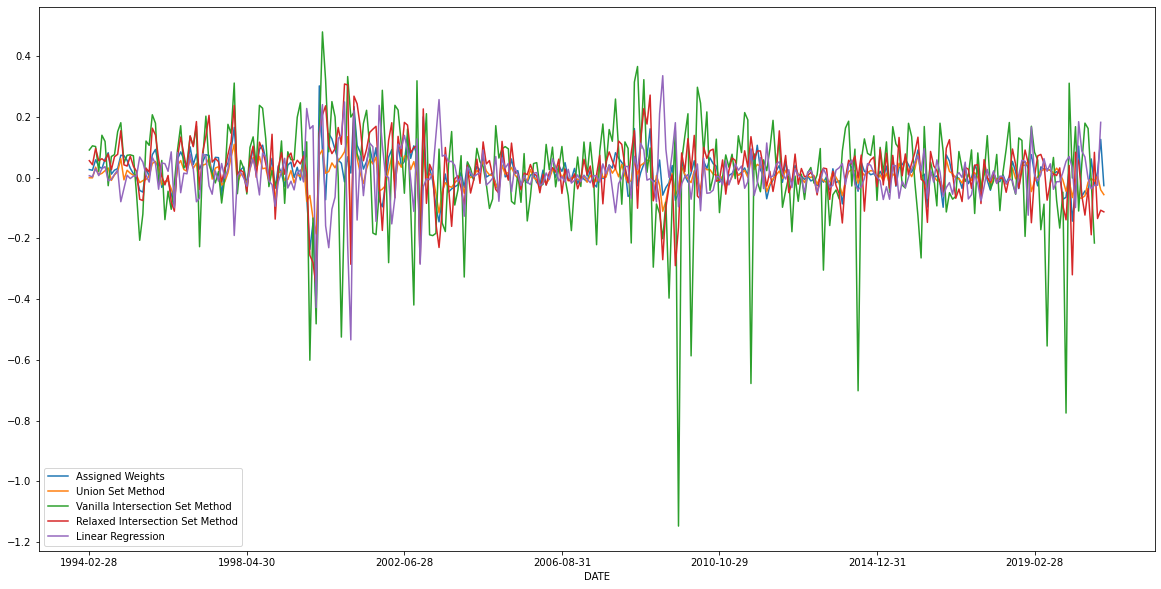

In [66]:
plt.figure(figsize=(20,10))
for i,r in enumerate(rets_list):
    if i<4: continue
    r.plot()
plt.legend(rets_list_labels[4:])

**Insights:** roughly speaking, intersection set method yields highest return for most dates, yet on the other hand, it also yields lowest return for most dates, too, which lead to a considerably lower average return

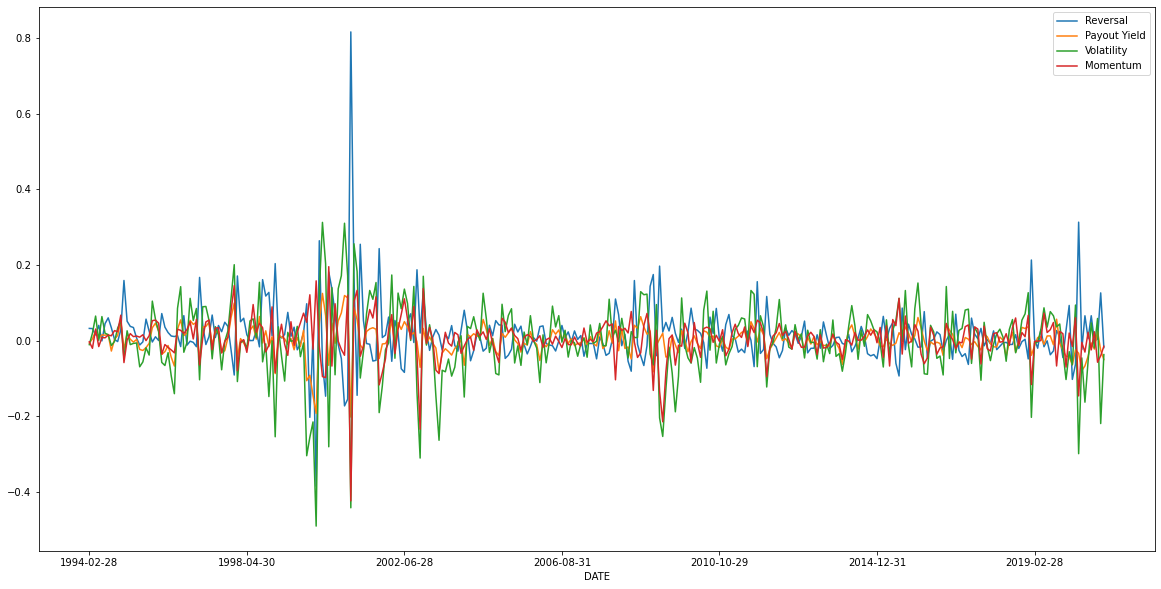

In [67]:
plt.figure(figsize=(20,10))
for i,r in enumerate(rets_list):
    if i==4: break
    r.plot()
plt.legend(rets_list_labels[:4])

**Insights:** roughly speaking, reversal yields highest returns for most dates, but we would like to compare individual strategies with combined strategies.

Text(0, 0.5, 'Return')

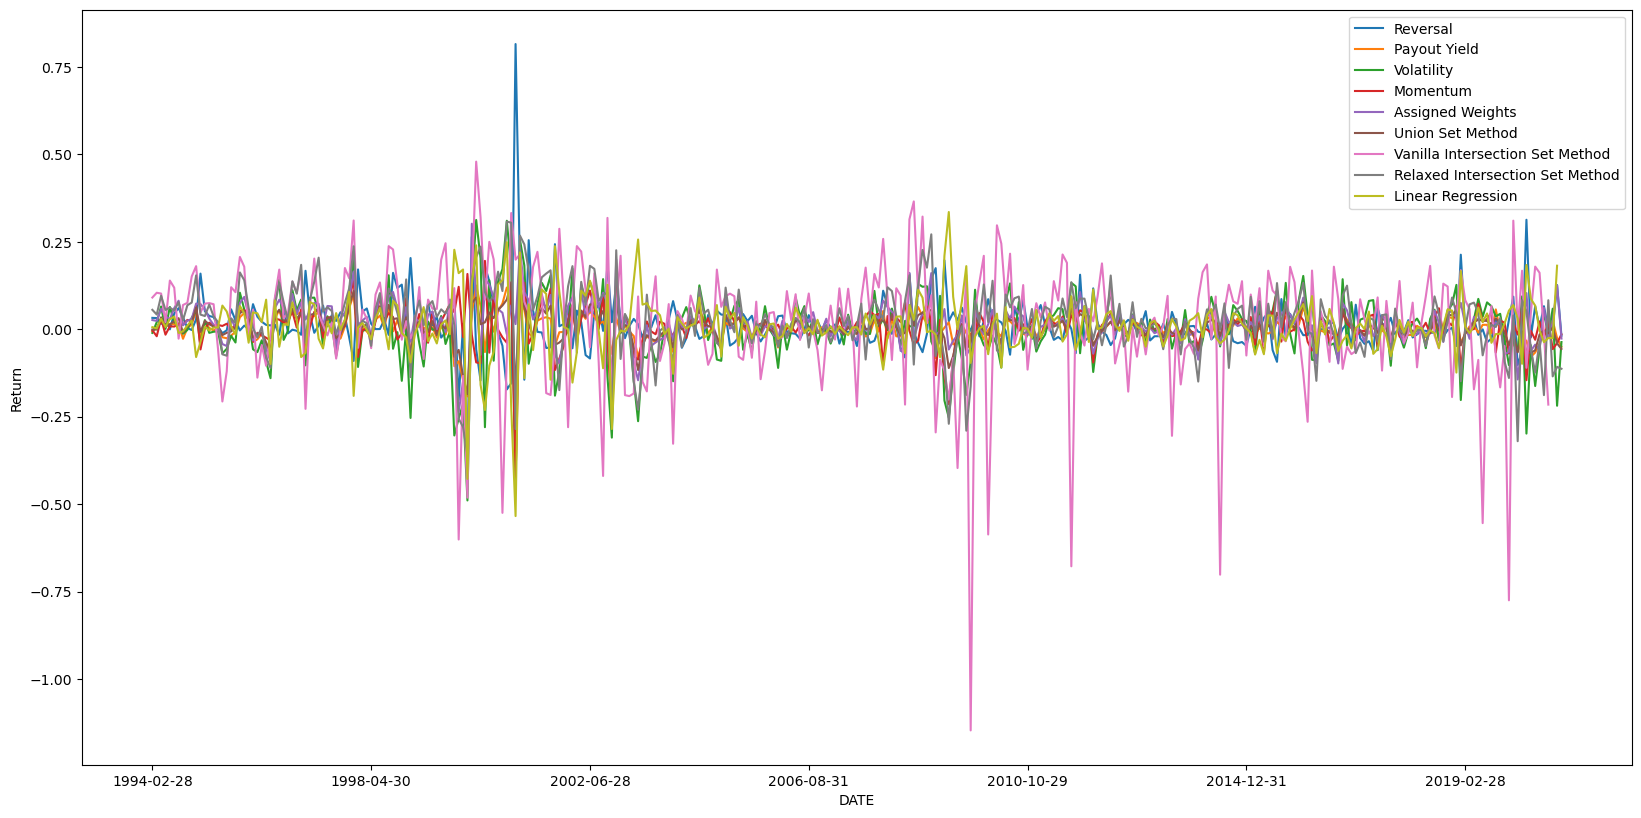

In [68]:
plt.figure(figsize=(20,10), dpi=100)
for i,r in enumerate(rets_list):
    r.plot()
plt.legend(rets_list_labels)
plt.ylabel('Return')

**Insights:** again, intersection set method yields highest return, as well as lowest return for most dates

In [69]:
rets = pd.DataFrame(ret_rev)
rets.columns = ['RET_0']
for i,r in enumerate(rets_list[1:]):
    rets = rets.merge(pd.DataFrame(r), how='outer', suffixes=(f'_{i}', f'_{i+1}'),
                     left_index=True, right_index=True)
rets

,RET_0,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8
DATE,,,,,,,,,
1994-02-28,0.032582,-0.006085,-0.010334,-0.002887,0.026338,-0.000722,0.090720,0.055590,0.006054
1994-03-31,0.032087,0.004984,0.020067,-0.019989,0.024014,-0.000916,0.104434,0.042182,0.002444
1994-04-29,0.015325,0.025306,0.065156,0.030879,0.058420,0.034182,0.102104,0.095881,0.029737
1994-05-31,0.040629,0.006746,0.001057,-0.015448,0.037521,0.009412,0.020221,0.055231,0.006477
1994-06-30,-0.000341,0.015498,0.063834,0.008608,0.028904,0.013761,0.139299,0.062033,0.029262
...,...,...,...,...,...,...,...,...,...
2020-08-31,0.066032,-0.006032,0.047375,-0.024202,0.061310,-0.003366,0.179136,-0.188287,-0.036846
2020-09-30,-0.000906,-0.022124,-0.018975,0.023680,-0.022046,-0.011616,0.161566,0.083027,-0.025053
2020-10-30,0.004399,0.024774,0.058838,-0.056772,0.018369,0.004793,NaN,-0.134755,-0.025198


In [70]:
rets['RET_max'] = rets.T.max()
rets['RET_argmax'] = np.array([rets.iloc[i, :9].argmax() for i in range(len(rets))])
rets

,RET_0,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_max,RET_argmax
DATE,,,,,,,,,,,
1994-02-28,0.032582,-0.006085,-0.010334,-0.002887,0.026338,-0.000722,0.090720,0.055590,0.006054,0.090720,6
1994-03-31,0.032087,0.004984,0.020067,-0.019989,0.024014,-0.000916,0.104434,0.042182,0.002444,0.104434,6
1994-04-29,0.015325,0.025306,0.065156,0.030879,0.058420,0.034182,0.102104,0.095881,0.029737,0.102104,6
1994-05-31,0.040629,0.006746,0.001057,-0.015448,0.037521,0.009412,0.020221,0.055231,0.006477,0.055231,7
1994-06-30,-0.000341,0.015498,0.063834,0.008608,0.028904,0.013761,0.139299,0.062033,0.029262,0.139299,6
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.066032,-0.006032,0.047375,-0.024202,0.061310,-0.003366,0.179136,-0.188287,-0.036846,0.179136,6
2020-09-30,-0.000906,-0.022124,-0.018975,0.023680,-0.022046,-0.011616,0.161566,0.083027,-0.025053,0.161566,6
2020-10-30,0.004399,0.024774,0.058838,-0.056772,0.018369,0.004793,NaN,-0.134755,-0.025198,0.058838,2


In [71]:
rets['RET_min'] = rets.iloc[i, :9].T.max()
rets['RET_argmin'] = np.array([rets.iloc[i, :9].argmin() for i in range(len(rets))])
rets

,RET_0,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_max,RET_argmax,RET_min,RET_argmin
DATE,,,,,,,,,,,,,
1994-02-28,0.032582,-0.006085,-0.010334,-0.002887,0.026338,-0.000722,0.090720,0.055590,0.006054,0.090720,6,0.069347,2
1994-03-31,0.032087,0.004984,0.020067,-0.019989,0.024014,-0.000916,0.104434,0.042182,0.002444,0.104434,6,0.069347,3
1994-04-29,0.015325,0.025306,0.065156,0.030879,0.058420,0.034182,0.102104,0.095881,0.029737,0.102104,6,0.069347,0
1994-05-31,0.040629,0.006746,0.001057,-0.015448,0.037521,0.009412,0.020221,0.055231,0.006477,0.055231,7,0.069347,3
1994-06-30,-0.000341,0.015498,0.063834,0.008608,0.028904,0.013761,0.139299,0.062033,0.029262,0.139299,6,0.069347,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.066032,-0.006032,0.047375,-0.024202,0.061310,-0.003366,0.179136,-0.188287,-0.036846,0.179136,6,0.069347,7
2020-09-30,-0.000906,-0.022124,-0.018975,0.023680,-0.022046,-0.011616,0.161566,0.083027,-0.025053,0.161566,6,0.069347,8
2020-10-30,0.004399,0.024774,0.058838,-0.056772,0.018369,0.004793,NaN,-0.134755,-0.025198,0.058838,2,0.069347,7


In [72]:
argmax = pd.DataFrame(rets['RET_argmax'].value_counts())
argmax.rename(index={i: rets_list_labels[i] for i in range(len(rets_list_labels))}, inplace=True)
argmax

,RET_argmax
Vanilla Intersection Set Method,131
Reversal,49
Linear Regression,45
Relaxed Intersection Set Method,37
Volatility,32
Assigned Weights,13
Momentum,11
Payout Yield,5


In [73]:
argmin = pd.DataFrame(rets['RET_argmin'].value_counts())
argmin.rename(index={i: rets_list_labels[i] for i in range(len(rets_list_labels))}, inplace=True)
argmin

,RET_argmin
Vanilla Intersection Set Method,76
Reversal,70
Volatility,58
Linear Regression,58
Momentum,22
Payout Yield,18
Relaxed Intersection Set Method,15
Assigned Weights,6


**Insights:** among all strategies, relaxed intersection set method yields highest return for a considerable amount of dates, and yields lowest return for considerably few dates, which explains the highest average return produced by relaxed intersection set method.

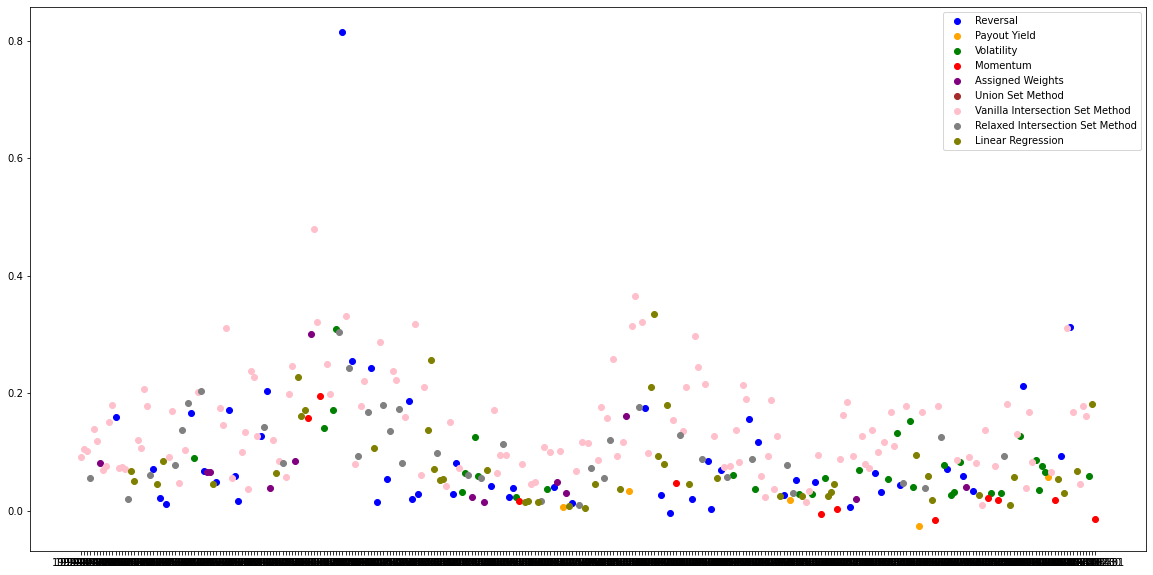

In [74]:
plt.figure(figsize=(20,10))
for i in range(len(rets_list_labels)):
    data_plot = pd.DataFrame(index=rets.index)
    tmp = rets.loc[rets['RET_argmax']==i, ['RET_max']]
    data_plot = data_plot.combine_first(tmp)
    plt.plot(data_plot.index, data_plot['RET_max'], 'o', color=color_list[i])
plt.legend(rets_list_labels)

In [75]:
results = rets.iloc[:, :-2].describe()
results.loc['sharpe_annual'] = results.loc['mean'] / results.loc['std'] * np.sqrt(12) #np.sqrt(250)
results.loc['tstat'] = results.loc['mean'] / (results.loc['std'] / np.sqrt(results.loc['count']))
results.rename(columns={f'RET_{i}': rets_list_labels[i] for i in range(len(rets_list_labels))}, 
               inplace=True)
results

,Reversal,Payout Yield,Volatility,Momentum,Assigned Weights,Union Set Method,Vanilla Intersection Set Method,Relaxed Intersection Set Method,Linear Regression,RET_max,RET_argmax
count,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,320.000000,323.000000,322.000000,323.000000,323.000000
mean,0.016882,0.000827,0.000470,0.005460,0.016091,0.005495,0.016380,0.024473,0.009347,0.107383,4.826625
std,0.080303,0.036973,0.098234,0.055015,0.062586,0.039005,0.178113,0.097503,0.082731,0.090575,2.686689
min,-0.384148,-0.201621,-0.489526,-0.422896,-0.429051,-0.185460,-1.147094,-0.358753,-0.534203,-0.026255,0.000000
25%,-0.016433,-0.015954,-0.045272,-0.016017,-0.014268,-0.011536,-0.052007,-0.018901,-0.022976,0.045595,2.000000
50%,0.008319,0.001867,0.000396,0.009470,0.014814,0.006388,0.040352,0.028237,0.006791,0.082222,6.000000
75%,0.036585,0.021849,0.054069,0.032091,0.048429,0.026061,0.116209,0.078334,0.045195,0.158661,7.000000
max,0.815640,0.125037,0.312614,0.195583,0.301760,0.134633,0.479381,0.308044,0.335305,0.815640,8.000000
sharpe_annual,0.728243,0.077484,0.016566,0.343827,0.890634,0.487989,0.318565,0.869470,0.391398,4.106928,6.223245
tstat,3.778217,0.401998,0.085946,1.783820,4.620723,2.531749,1.645062,4.510919,2.027476,21.307267,32.286988


### Best Strategy Analysis

In [76]:
Graph = pd.DataFrame(ports_best)
Graph = Graph.reset_index().set_index('DATE')
Graph['RET'] = Graph['RET']*Graph['method2_relaxed']

In [77]:
Graph = pd.DataFrame(Graph.groupby('DATE')['RET'].sum())
Graph

,RET
DATE,
1994-02-28,0.055590
1994-03-31,0.042182
1994-04-29,0.095881
1994-05-31,0.055231
1994-06-30,0.062033
...,...
2020-08-31,-0.188287
2020-09-30,0.083027
2020-10-30,-0.134755


In [78]:
# monthly data
rf = pd.read_csv('Data/risk-free_return.csv')
rf['DATE'] = pd.to_datetime(rf['DATE'])
rf.set_index('DATE', inplace=True)
rf

,RF
DATE,
1926-07-31,0.0022
1926-08-31,0.0025
1926-09-30,0.0023
1926-10-31,0.0032
1926-11-30,0.0031
...,...
2018-03-31,0.0012
2018-04-30,0.0014
2018-05-31,0.0014


In [79]:
# daily data
sp = pd.read_csv('Data/SPY.csv')
# sp['R'] = sp['Adj Close'].pct_change()
# sp = sp.set_index('Date')[['R']]
sp['Date'] = pd.to_datetime(sp['Date'])
sp

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.717396,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.900295,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.955158,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.229527,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.339272,531500
...,...,...,...,...,...,...,...
7209,2021-09-15,444.619995,448.410004,443.440002,447.880005,446.449738,78792200
7210,2021-09-16,447.320007,448.359985,444.019989,447.170013,445.742004,77786700
7211,2021-09-17,444.920013,445.369995,441.019989,441.399994,441.399994,118220200
7212,2021-09-20,434.880005,436.559998,428.859985,434.040009,434.040009,166445500


In [80]:
sp['ym'] = sp['Date'].dt.to_period('M')
sp['ym_lead'] = sp['ym'].shift(-1)
sp = sp.loc[sp['ym_lead']!=sp['ym']]
sp['R'] = sp['Adj Close'].pct_change()
sp=sp.set_index('Date')[['R']]
sp.head()

/Users/antheayang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,R
Date,
1993-01-29,NaN
1993-02-26,0.010667
1993-03-31,0.022400
1993-04-30,-0.025588
1993-05-28,0.026970


In [81]:
Graph.index = pd.to_datetime(Graph.index)
sp.index = pd.to_datetime(sp.index)

In [82]:
g = Graph.join(sp)
g.index = pd.to_datetime(g.index, format="%Y%m") + MonthEnd(0)
#.join(rf)
g = Graph.join(sp).join(rf).fillna(method='bfill')
g.head()

,RET,R,RF
DATE,,,
1994-02-28,0.055590,-0.029164,0.0021
1994-03-31,0.042182,-0.041901,0.0027
1994-04-29,0.095881,0.011212,0.0031
1994-05-31,0.055231,0.015938,0.0031
1994-06-30,0.062033,-0.022914,0.0031


In [83]:
g['RET'] = g['RET']+1 # Strategy
g['R'] = g['R']+1 # Market
g['RF'] = g['RF']+1 # Risk free
g.head()

,RET,R,RF
DATE,,,
1994-02-28,1.055590,0.970836,1.0021
1994-03-31,1.042182,0.958099,1.0027
1994-04-29,1.095881,1.011212,1.0031
1994-05-31,1.055231,1.015938,1.0031
1994-06-30,1.062033,0.977086,1.0031


In [84]:
g_tmp = g.copy()

In [85]:
g['RET_Cumprod'] = g['RET'].cumprod()
g['R_Cumprod'] = g['R'].cumprod()
g['RF_Cumprod'] = g['RF'].cumprod()
g.tail()

,RET,R,RF,RET_Cumprod,R_Cumprod,RF_Cumprod
DATE,,,,,,
2020-08-31,0.811713,1.069797,NaN,702.042382,11.858229,NaN
2020-09-30,1.083027,0.962556,NaN,760.330961,11.414214,NaN
2020-10-30,0.865245,0.975066,NaN,657.872629,11.129617,NaN
2020-11-30,0.892549,1.108777,NaN,587.183445,12.340261,NaN
2020-12-31,0.887089,1.037048,NaN,520.883947,12.797448,NaN


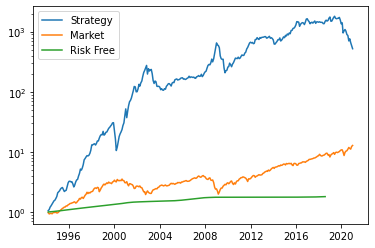

In [86]:
plt.yscale('log')
plt.plot('RET_Cumprod', data=g,label='Strategy')
plt.plot('R_Cumprod', data=g, label='Market')
plt.plot('RF_Cumprod', data=g, label='Risk Free')
plt.legend()

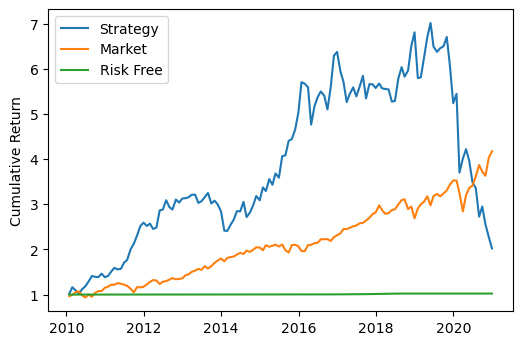

In [88]:
g_tmp = g_tmp.loc[g_tmp.index>='2010-01-01']
g_tmp['RET_Cumprod'] = g_tmp['RET'].cumprod()
g_tmp['R_Cumprod'] = g_tmp['R'].cumprod()
g_tmp['RF_Cumprod'] = g_tmp['RF'].cumprod()
g_tmp['RF_Cumprod'] = g_tmp['RF_Cumprod'].fillna(method='ffill')
# plt.yscale('log')
plt.figure(dpi=100)
plt.plot('RET_Cumprod', data=g_tmp, label='Strategy')
plt.plot('R_Cumprod', data=g_tmp, label='Market')
plt.plot('RF_Cumprod', data=g_tmp, label='Risk Free')
plt.ylabel('Cumulative Return')
plt.legend()